# NBEATSx MODEL

In [1]:
#allows imports from other folders in project
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Epoch 1/100, Loss: 9.389925
Epoch 2/100, Loss: 13.266009
Epoch 3/100, Loss: 2.530644
Epoch 4/100, Loss: 1.579610
Epoch 5/100, Loss: 0.353977
Epoch 6/100, Loss: 0.115258
Epoch 7/100, Loss: 0.024963
Epoch 8/100, Loss: 0.033063
Epoch 9/100, Loss: 0.017696
Epoch 10/100, Loss: 0.012420
Epoch 11/100, Loss: 0.007029
Epoch 12/100, Loss: 0.005424
Epoch 13/100, Loss: 0.007289
Epoch 14/100, Loss: 0.003548
Epoch 15/100, Loss: 0.002809
Epoch 16/100, Loss: 0.003496
Epoch 17/100, Loss: 0.003825
Epoch 18/100, Loss: 0.002110
Epoch 19/100, Loss: 0.001968
Epoch 20/100, Loss: 0.001738
Epoch 21/100, Loss: 0.001119
Epoch 22/100, Loss: 0.002609
Epoch 23/100, Loss: 0.001153
Epoch 24/100, Loss: 0.000630
Epoch 25/100, Loss: 0.001093
Epoch 26/100, Loss: 0.004473
Epoch 27/100, Loss: 0.000812
Epoch 28/100, Loss: 0.000881
Epoch 29/100, Loss: 0.001104
Epoch 30/100, Loss: 0.000513
Epoch 31/100, Loss: 0.000736
Epoch 32/100, Loss: 0.000808
Epoch 33/100, Loss: 0.001949
Epoch 34/100, Loss: 0.000822
Epoch 35/100, Loss: 0.

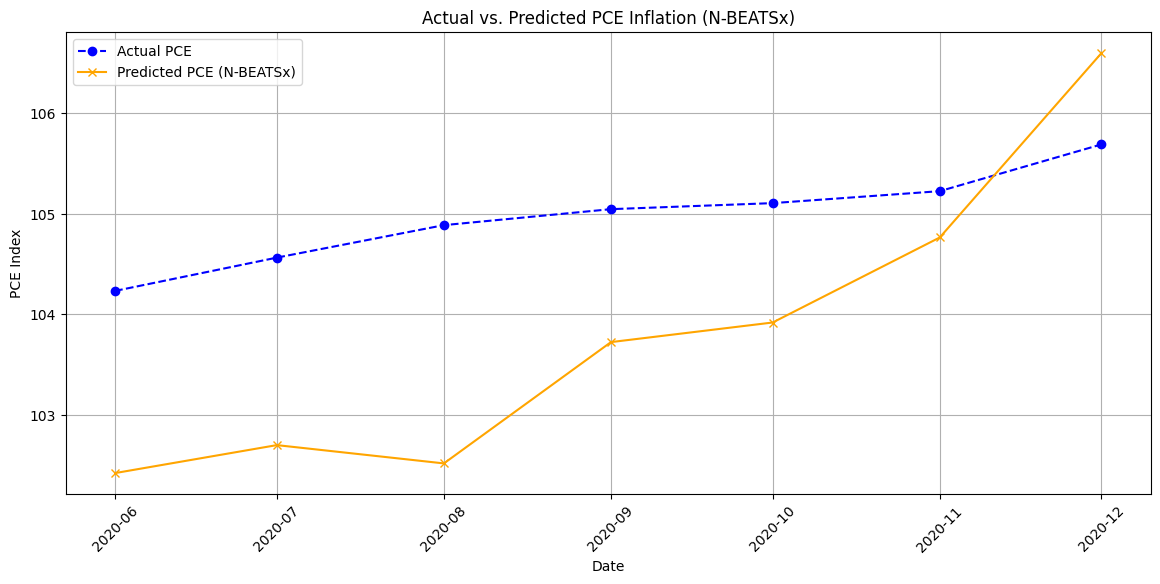


 Model Evaluation Metrics: 
Mean Absolute Error (MAE): 1.4176
Root Mean Squared Error (RMSE): 1.5383
Mean Absolute Percentage Error (MAPE): 1.35%


In [2]:
import torch
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from Models.NBEATSx import NBeatsx  # Import N-BEATSx model
from dataPreprocessing import load_data, prepare_dataloader  # Import preprocessing functions

# Load Data with Exogenous & FFT Features
train_file = "../Data/Train/train1990s.csv"
config = {
    "use_fft": False,  # Enable Fourier features
    "use_exog": True  # Enable exogenous variables
}
X_train, X_exog_train, y_train, X_valid, X_exog_valid, y_valid, X_test, X_exog_test, y_test, dates, scaler, exog_scaler, y_scaler = load_data(train_file, config=config)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_exog_train_tensor = torch.tensor(X_exog_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
X_exog_valid_tensor = torch.tensor(X_exog_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_exog_test_tensor = torch.tensor(X_exog_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, X_exog_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid_tensor, X_exog_valid_tensor, y_valid_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, X_exog_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# Initialize Model
model = NBeatsx(input_size=X_train.shape[1], exog_size=X_exog_train.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)  # Increased weight decay
criterion = torch.nn.SmoothL1Loss()  # Change from HuberLoss to SmoothL1Loss

# Train Model
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, exog_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch, exog_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}')

train_model(model, train_loader, criterion, optimizer, epochs=100)

# Evaluate Model on Test Data
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, exog_batch, y_batch in test_loader:
        y_pred = model(X_batch, exog_batch).cpu().numpy()
        predictions.extend(y_pred)
        actuals.extend(y_batch.cpu().numpy())

# Convert Predictions Back to Original Scale
predictions = np.array(predictions)
actuals = np.array(actuals)
predictions = y_scaler.inverse_transform(predictions)
actuals = y_scaler.inverse_transform(actuals)

# Plot Predictions
plt.figure(figsize=(14, 6))
plt.plot(dates[-len(predictions):], actuals, label="Actual PCE", marker='o', linestyle='dashed', color='blue')
plt.plot(dates[-len(predictions):], predictions, label="Predicted PCE (N-BEATSx)", marker='x', linestyle='solid', color='orange')
plt.legend()
plt.title("Actual vs. Predicted PCE Inflation (N-BEATSx)")
plt.xlabel("Date")
plt.ylabel("PCE Index")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Evaluate Model Performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print("\n Model Evaluation Metrics: ")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
